In [19]:
import numpy as np
import cvxpy as cp
from skimage import img_as_float, io
from time import process_time
import matplotlib.pyplot as plt
from tfgraph import *

In [20]:
def soft_thresholding(x, lam):
    return np.sign(x) * np.maximum(np.abs(x) - lam, 0)

## ADMM

In [21]:
# The ADMM_on_graphs function may not always run correctly when k is even due to the convex optimization step for updating z using CVXPY. 
def ADMM_on_graphs(image,k,lambd,rho,max_iter=100,tol=1e-4):
    """
    Runs the ADMM (Alternating Direction Method of Multipliers) algorithm on graph structures derived from the image 
    for trend filtering on the graph.

    Parameters:
    - image: Input image data as a 2D array
    - k: Degree of the filter, determining the level of smoothing (even or odd values affect the calculation method)
    - lambd: Regularization parameter
    - rho: Penalty parameter in ADMM
    
    Returns:
    - beta: The filtered result after applying ADMM
    - i: Number of iterations performed
    - primal_residuals: List of primal residuals across iterations
    - dual_residuals: List of dual residuals across iterations
    """
    begin = process_time()
    y = image.flatten(order='F')
    n = y.shape[0]

    L = generate_L(image)
    beta = np.zeros(n)
    z = np.zeros(n)
    u = np.zeros(n)

    primal_residuals = []
    dual_residuals = []
    if k%2 == 0:
        S=generate_D(image)
        q = k//2
    else:
        S=L
        q = (k+1)//2
    Lq=np.linalg.matrix_power(L, q)
    L2q=np.linalg.matrix_power(L, 2*q)

    for i in range(max_iter):
        # Update beta
        b = y + rho * Lq.T @ (z + u)
        A= np.eye(n) + rho * L2q
        beta = np.linalg.solve(A, b)

        # Update z
        if k % 2 == 0:
            z_var = cp.Variable(n)
            objective = cp.Minimize((lambd / rho) * cp.norm1(S @ z_var) + 0.5 * cp.sum_squares(Lq @ beta - z_var - u))
            problem = cp.Problem(objective)
            result = problem.solve(solver=cp.ECOS)

            if z_var.value is not None:
                z = z_var.value
            else:
                print("Warning: Solver failed to find a feasible solution for z. Using previous z value.")
                z = z
        else:
            z = soft_thresholding(Lq @ beta - u, lambd / rho)
            
        # Update dual variable u
        u = u - Lq @ beta + z

        # Calculate primal and dual residuals
        primal_residual = Lq @ beta - z
        dual_residual = rho * Lq @ (z - u)
        primal_residuals.append(np.linalg.norm(primal_residual))
        dual_residuals.append(np.linalg.norm(dual_residual))

        # Check for convergence
        if primal_residuals[-1] < tol:
            break
    end = process_time()
    print("----- ADMM on Graphs-----")
    print("Time execution:", end - begin)    
    return beta, i, primal_residuals, dual_residuals


In [22]:
# Generate a test image (a small matrix for testing)
np.random.seed(123)
test_image = np.random.rand(15, 15)

# Run the ADMM_on_graphs function
k = 1
lambd = 1
rho = 1


beta, iterations, primal_residuals, dual_residuals = ADMM_on_graphs(test_image, k, lambd, rho)
trend_image = beta.reshape(test_image.shape)
print("Number of iterations:", iterations)


----- ADMM on Graphs-----
Time execution: 52.85442903300009
Number of iterations: 99


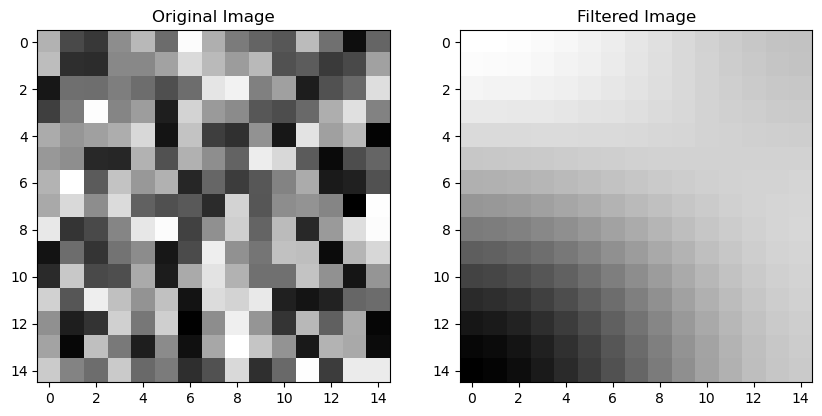

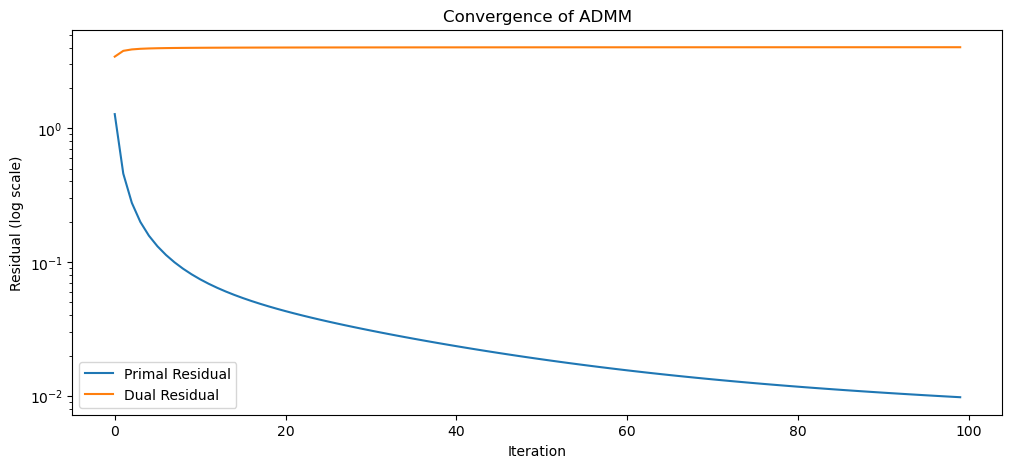

In [23]:
# Print results
plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(test_image, cmap='gray')
plt.title("Original Image")

# Filtered image
plt.subplot(1, 2, 2)
plt.imshow(trend_image, cmap='gray')
plt.title("Filtered Image")

plt.show()

# Plot primal and dual residuals to check convergence
plt.figure(figsize=(12, 5))

plt.plot(primal_residuals, label='Primal Residual')
plt.plot(dual_residuals, label='Dual Residual')
plt.yscale('log')  # Use log scale to better visualize convergence
plt.xlabel('Iteration')
plt.ylabel('Residual (log scale)')
plt.title('Convergence of ADMM')
plt.legend()

plt.show()

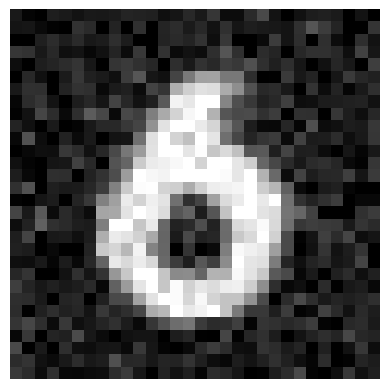

In [24]:
from PIL import Image
image_path = '6.png'  # 替换为你的图片路径
image = Image.open(image_path)

# 转换为灰度图像
gray_image = image.convert('L').resize((30,30))

# 将灰度图像转换为 NumPy 数组
gray_image_np = np.array(gray_image)

def add_gaussian_noise(image, mean=0, std=25):
    noise = np.random.normal(mean, std, image.shape)  # 生成高斯噪声
    noisy_image = image + noise  # 添加噪声
    noisy_image = np.clip(noisy_image, 0, 255)  # 确保值在[0, 255]范围内
    return noisy_image

# 添加噪声到图像
image = add_gaussian_noise(gray_image_np)

plt.imshow(image, cmap='gray')
plt.axis('off')  # 不显示坐标轴
plt.show()

----- ADMM on Graphs-----
Time execution: 273.6785327100001
Number of iterations: 99


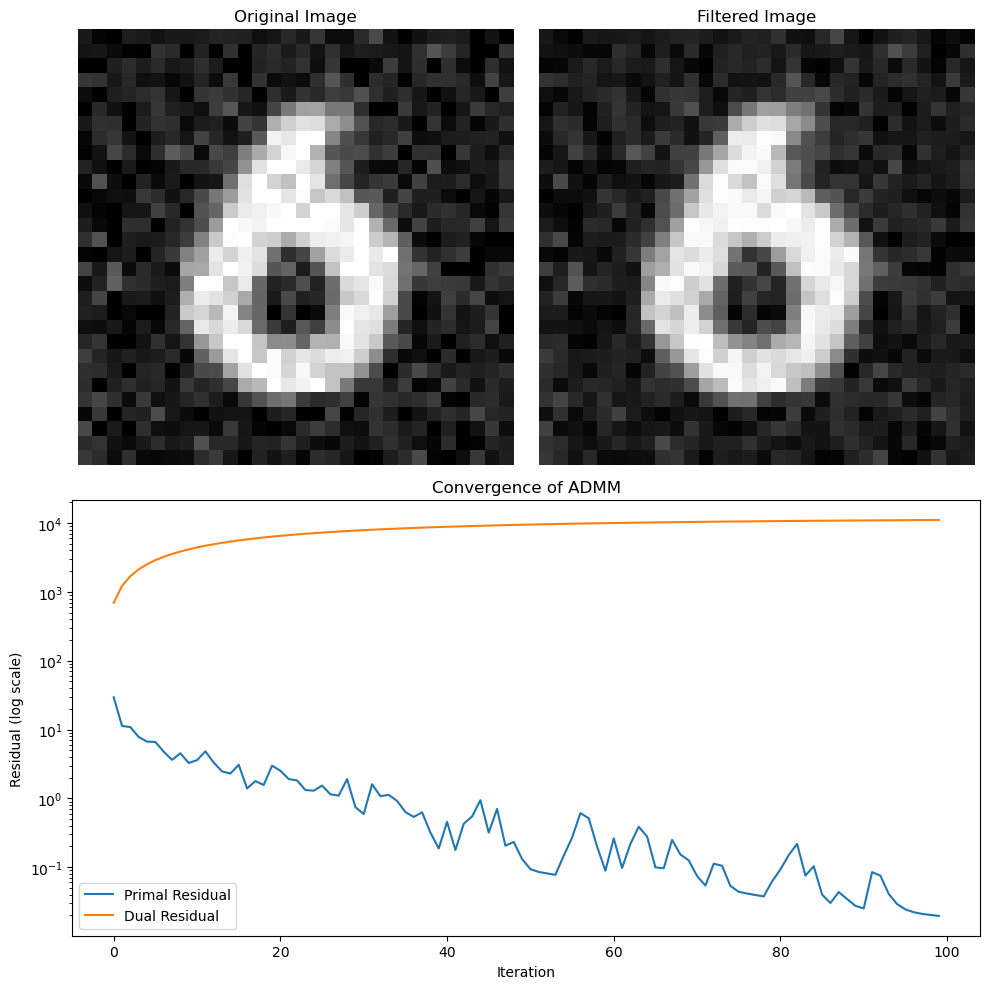

In [25]:
k = 1
lambd = 1
rho = 1
beta, iterations, primal_residuals, dual_residuals = ADMM_on_graphs(image, k, lambd, rho)

trend_image = beta.reshape(image.shape,order='F')
print("Number of iterations:", iterations)
plt.figure(figsize=(10, 10))

# Original image
plt.subplot(2, 2, 1)
plt.imshow(image, cmap='gray')
plt.title("Original Image")
plt.axis('off')

# Filtered image
plt.subplot(2, 2, 2)
plt.imshow(trend_image, cmap='gray')
plt.title("Filtered Image")
plt.axis('off')

# Plot primal and dual residuals to check convergence
plt.subplot(2, 1, 2)
plt.plot(primal_residuals, label='Primal Residual')
plt.plot(dual_residuals, label='Dual Residual')
plt.yscale('log')  # Use log scale to better visualize convergence
plt.xlabel('Iteration')
plt.ylabel('Residual (log scale)')
plt.title('Convergence of ADMM')
plt.legend()

plt.tight_layout()
plt.show()

----- ADMM on Graphs-----
Time execution: 276.29876259000025
Number of iterations: 99


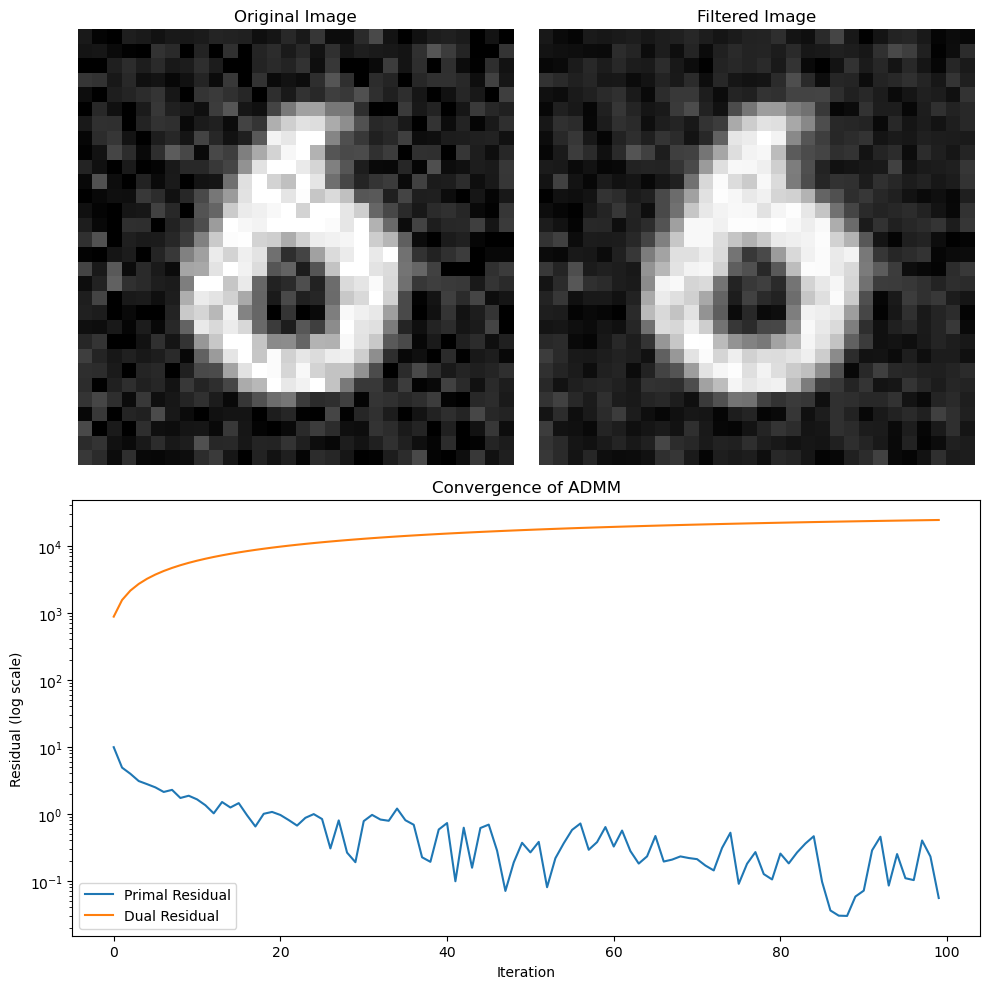

In [26]:
lambd = 1
rho = 3
beta, iterations, primal_residuals, dual_residuals = ADMM_on_graphs(image, k, lambd, rho)

trend_image = beta.reshape(image.shape,order='F')
print("Number of iterations:", iterations)
plt.figure(figsize=(10, 10))

# Original image
plt.subplot(2, 2, 1)
plt.imshow(image, cmap='gray')
plt.title("Original Image")
plt.axis('off')

# Filtered image
plt.subplot(2, 2, 2)
plt.imshow(trend_image, cmap='gray')
plt.title("Filtered Image")
plt.axis('off')

# Plot primal and dual residuals to check convergence
plt.subplot(2, 1, 2)
plt.plot(primal_residuals, label='Primal Residual')
plt.plot(dual_residuals, label='Dual Residual')
plt.yscale('log')  # Use log scale to better visualize convergence
plt.xlabel('Iteration')
plt.ylabel('Residual (log scale)')
plt.title('Convergence of ADMM')
plt.legend()

plt.tight_layout()
plt.show()

----- ADMM on Graphs-----
Time execution: 116.18791907000013
Number of iterations: 39


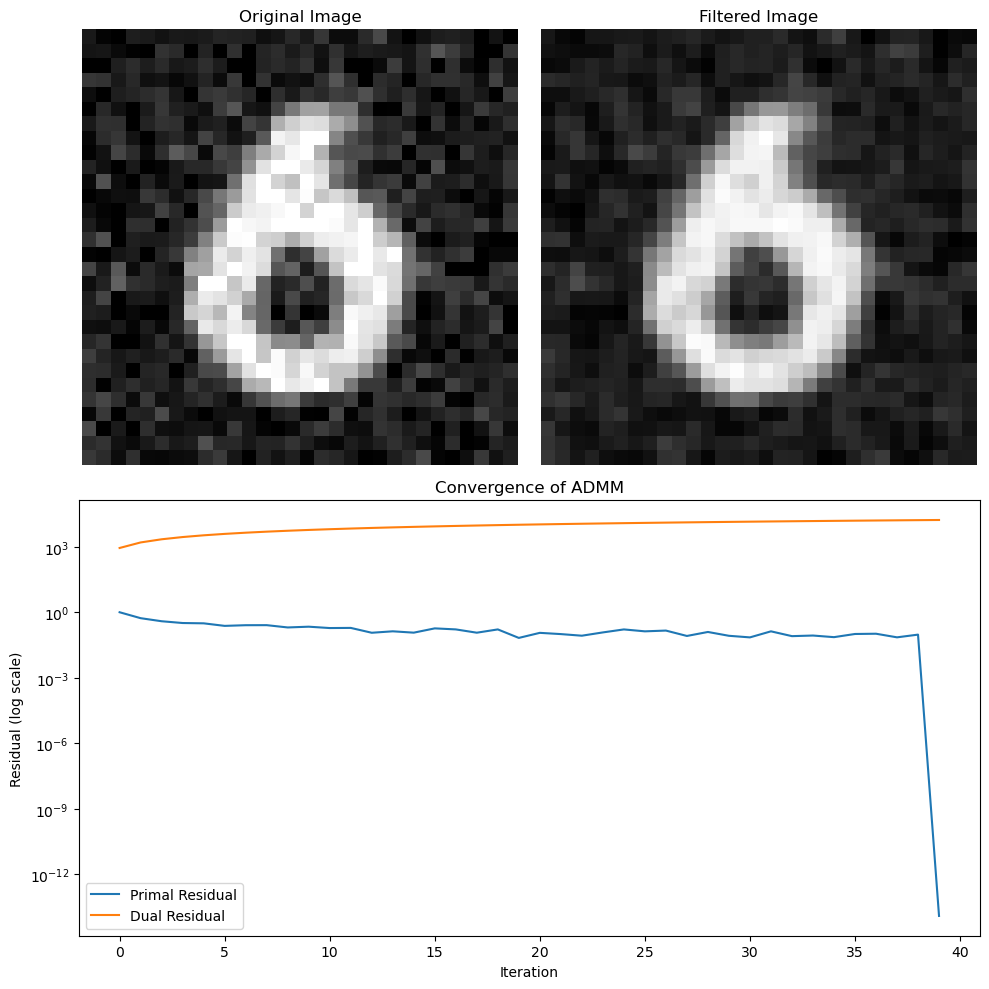

In [27]:
lambd = 0.1
rho = 3
beta, iterations, primal_residuals, dual_residuals = ADMM_on_graphs(image, k, lambd, rho)

trend_image = beta.reshape(image.shape,order='F')
print("Number of iterations:", iterations)
plt.figure(figsize=(10, 10))

# Original image
plt.subplot(2, 2, 1)
plt.imshow(image, cmap='gray')
plt.title("Original Image")
plt.axis('off')

# Filtered image
plt.subplot(2, 2, 2)
plt.imshow(trend_image, cmap='gray')
plt.title("Filtered Image")
plt.axis('off')

# Plot primal and dual residuals to check convergence
plt.subplot(2, 1, 2)
plt.plot(primal_residuals, label='Primal Residual')
plt.plot(dual_residuals, label='Dual Residual')
plt.yscale('log')  # Use log scale to better visualize convergence
plt.xlabel('Iteration')
plt.ylabel('Residual (log scale)')
plt.title('Convergence of ADMM')
plt.legend()

plt.tight_layout()
plt.show()

----- ADMM on Graphs-----
Time execution: 112.68076881199977
Number of iterations: 39


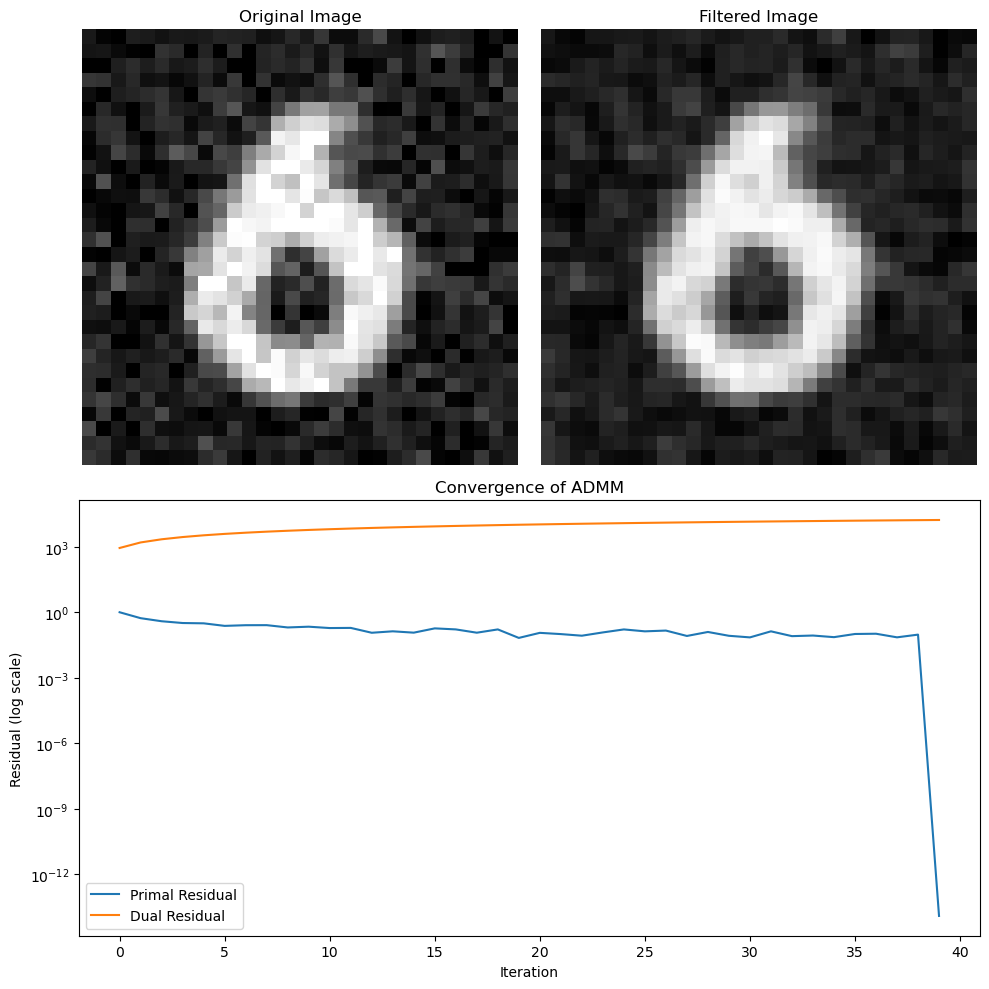

In [28]:
lambd = 0.1
rho = 3
beta, iterations, primal_residuals, dual_residuals = ADMM_on_graphs(image, k, lambd, rho)

trend_image = beta.reshape(image.shape,order='F')
print("Number of iterations:", iterations)
plt.figure(figsize=(10, 10))

# Original image
plt.subplot(2, 2, 1)
plt.imshow(image, cmap='gray')
plt.title("Original Image")
plt.axis('off')

# Filtered image
plt.subplot(2, 2, 2)
plt.imshow(trend_image, cmap='gray')
plt.title("Filtered Image")
plt.axis('off')

# Plot primal and dual residuals to check convergence
plt.subplot(2, 1, 2)
plt.plot(primal_residuals, label='Primal Residual')
plt.plot(dual_residuals, label='Dual Residual')
plt.yscale('log')  # Use log scale to better visualize convergence
plt.xlabel('Iteration')
plt.ylabel('Residual (log scale)')
plt.title('Convergence of ADMM')
plt.legend()

plt.tight_layout()
plt.show()

----- ADMM on Graphs-----
Time execution: 250.91437817999986
Number of iterations: 99


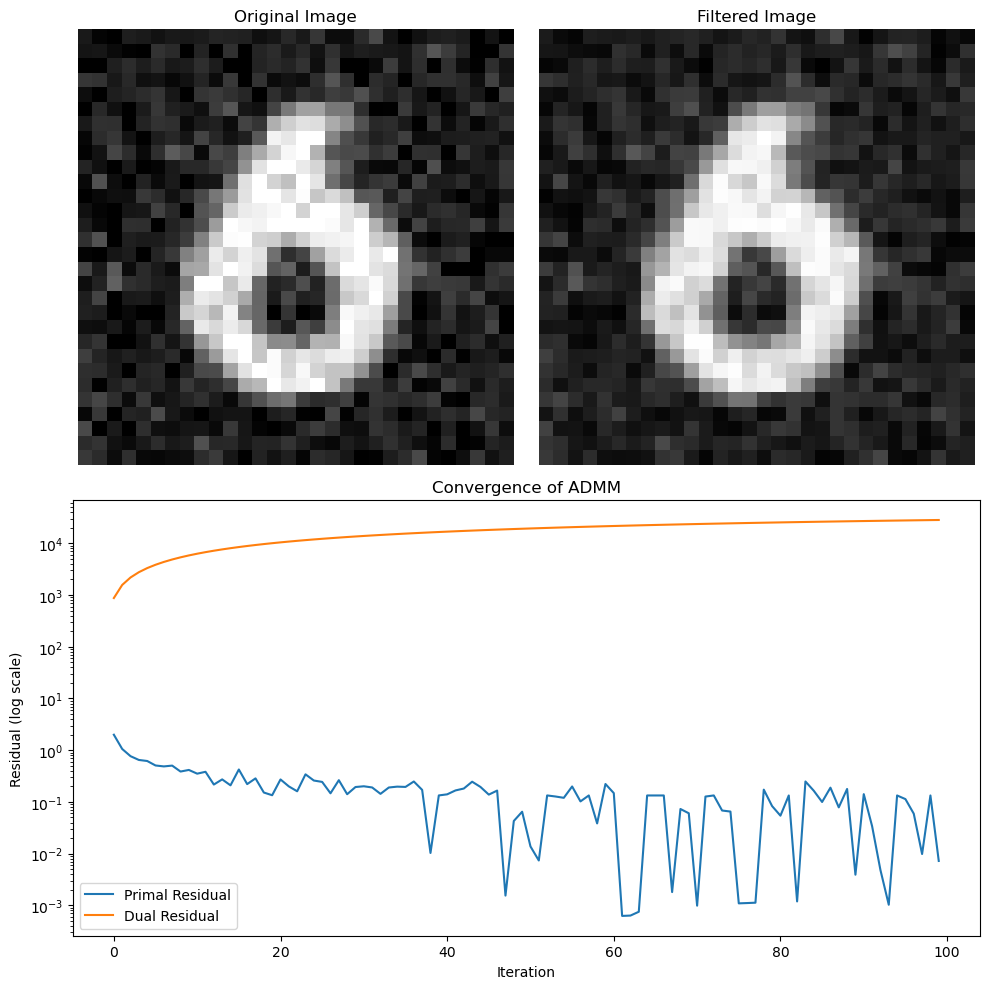

In [29]:
lambd = 0.2
rho = 3
beta, iterations, primal_residuals, dual_residuals = ADMM_on_graphs(image, k, lambd, rho)

trend_image = beta.reshape(image.shape,order='F')
print("Number of iterations:", iterations)
plt.figure(figsize=(10, 10))

# Original image
plt.subplot(2, 2, 1)
plt.imshow(image, cmap='gray')
plt.title("Original Image")
plt.axis('off')

# Filtered image
plt.subplot(2, 2, 2)
plt.imshow(trend_image, cmap='gray')
plt.title("Filtered Image")
plt.axis('off')

# Plot primal and dual residuals to check convergence
plt.subplot(2, 1, 2)
plt.plot(primal_residuals, label='Primal Residual')
plt.plot(dual_residuals, label='Dual Residual')
plt.yscale('log')  # Use log scale to better visualize convergence
plt.xlabel('Iteration')
plt.ylabel('Residual (log scale)')
plt.title('Convergence of ADMM')
plt.legend()

plt.tight_layout()
plt.show()

## Fast Newton

In [30]:
from scipy.sparse.linalg import cg 
def projected_newton_method(y, Delta, lambd, max_iter=100, tol=1e-4):
    """
    Implements the projected Newton method for solving the dual problem.
    
    Parameters:
    - y: numpy array, target vector.
    - Delta: numpy array, the matrix Δ^(k+1).
    - lambd: float, constraint value for the l1 norm.
    - max_iter: int, maximum number of iterations.
    - tol: float, tolerance for convergence.
    
    Returns:
    - v: solution vector.
    - beta: solution of the original problem.
    """
    # Initialize variables
    v = np.zeros(Delta.shape[1])  # Initialize v
    I = np.arange(Delta.shape[1])  # Indices of all elements

    for iteration in range(max_iter):
        # Compute gradient g and reduced Hessian H
        g = Delta.T @ (Delta @ v - y)  # Gradient of the dual objective
        Hv = Delta.T @ Delta  # Reduced Hessian, typically sparse

        # Solve the linear system using a conjugate gradient solver
        # Here we use cg (conjugate gradient) with tolerance for improved conditioning
        a, _ = cg(Hv, g, tol=tol)

        # Perform update for v: v = v - a
        v -= a

        # Project v to satisfy the l1 constraint ||v||_1 <= lambd
        # Using soft thresholding as projection
        v = project_l1(v, lambd)

        # Check convergence
        if np.linalg.norm(g, 2) < tol:
            print(f"Converged in {iteration} iterations.")
            break

    # Compute beta from v
    beta = y - Delta.T @ v
    return v, beta

def project_l1(v, lambd):
    """Projects vector v onto the l1-norm ball of radius lambd."""
    if np.sum(np.abs(v)) <= lambd:
        return v
    else:
        u = np.abs(v)
        if u.sum() == 0:
            return v
        w = np.sort(u)[::-1]
        sv = np.cumsum(w)
        rho = np.where(w > (sv - lambd) / (np.arange(1, len(w) + 1)))[0][-1]
        theta = (sv[rho] - lambd) / (rho + 1)
        return np.sign(v) * np.maximum(u - theta, 0)


In [31]:
def Newton_for_tf(image, k, alpha, max_iter=100, tol=1e-4):
    begin = process_time()
    y = image.flatten(order='F')
    n = y.shape[0]
    L=generate_L(image)
    D=generate_D(image)
    Delta = generate_delta(L, D, k)

    Hessian = Delta.T @ Delta
    v = np.zeros(Delta.shape[1])
    



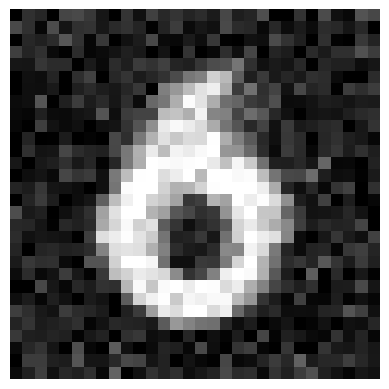

In [33]:
image_path = '6.png'  # 替换为你的图片路径
image = Image.open(image_path)

# 转换为灰度图像
gray_image = image.convert('L').resize((30,30))

# 将灰度图像转换为 NumPy 数组
gray_image_np = np.array(gray_image)

def add_gaussian_noise(image, mean=0, std=25):
    noise = np.random.normal(mean, std, image.shape)  # 生成高斯噪声
    noisy_image = image + noise  # 添加噪声
    noisy_image = np.clip(noisy_image, 0, 255)  # 确保值在[0, 255]范围内
    return noisy_image

# 添加噪声到图像
image = add_gaussian_noise(gray_image_np)

plt.imshow(image, cmap='gray')
plt.axis('off')  # 不显示坐标轴
plt.show()


----- ADMM on Graphs-----
Time execution: 309.6363348770001
Number of iterations: 99


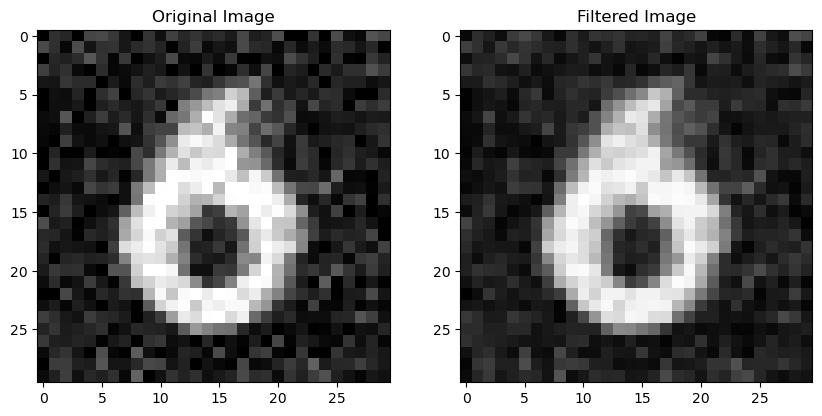

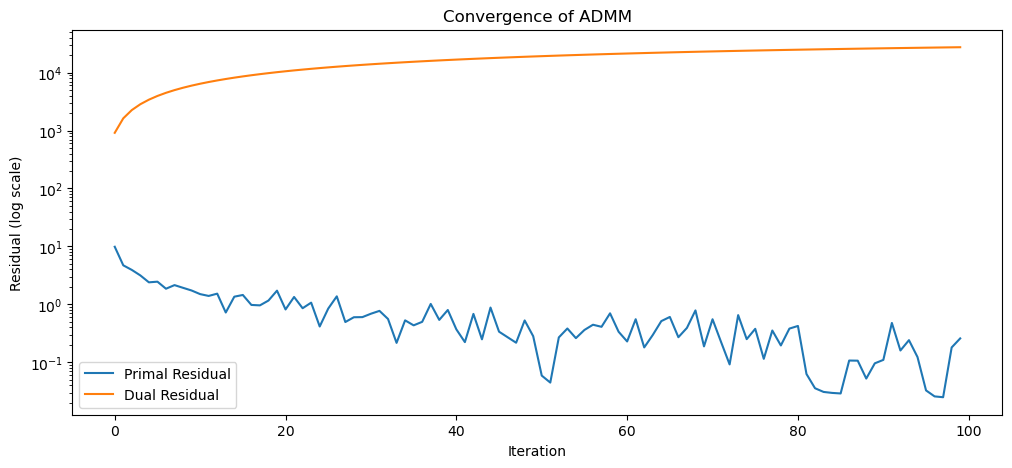

In [35]:
beta, iterations, primal_residuals, dual_residuals = ADMM_on_graphs(image, k, lambd, rho)
trend_image = beta.reshape(image.shape, order="F")
print("Number of iterations:", iterations)

# Print results
plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title("Original Image")

# Filtered image
plt.subplot(1, 2, 2)
plt.imshow(trend_image, cmap='gray')
plt.title("Filtered Image")

plt.show()

# Plot primal and dual residuals to check convergence
plt.figure(figsize=(12, 5))

plt.plot(primal_residuals, label='Primal Residual')
plt.plot(dual_residuals, label='Dual Residual')
plt.yscale('log')  # Use log scale to better visualize convergence
plt.xlabel('Iteration')
plt.ylabel('Residual (log scale)')
plt.title('Convergence of ADMM')
plt.legend()

plt.show()